<a href="https://colab.research.google.com/github/bmacedo6/Repository-F2/blob/main/sem_ai_algo_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmic Trading

Seminario: Inteligencia Artificial en las Finanzas

Profesores: A. Mendiola, PhD. y F. Rosales, PhD.

## Data Loading

In [ ]:
# Specialized libraries
!pip install schedule
!pip install krakenex

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import schedule
import krakenex
from google.colab import files

In [ ]:
# Authentication
def load_api_keys(filepath):
  with open(filepath, 'r') as file:
    lines = file.readlines()
    api_key = lines[0].strip().split('=')[1]
    api_secret = lines[1].strip().split('=')[1]
  return api_key, api_secret

In [ ]:
# Fetch OHLC data from Kraken
def get_ohlc_data(pair = 'XXBTZUSD', interval = 1, start = None):
  params = {'pair': pair, 'interval': interval}
  if start is not None:
    start_timestamp = int(pd.Timestamp(start).timestamp())
    params['since'] = start_timestamp

    response = api.query_public('OHLC', params)
    data = response['result'][pair]
    df = pd.DataFrame(data, columns = ['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])
    df['time'] = pd.to_datetime(df['time'], unit = 's')
    df.set_index('time', inplace = True)
    df = df.astype(float)
  return df

## Definición de la Estrategia

In [ ]:
# Long moving average (LMA) and short moving average (SMA)

def calculate_lma_sma(data, l, s):
  data['LMA'] = data['close'].rolling(window = l).mean()
  data['SMA'] = data['close'].rolling(window = s).mean()
  data['C'] = data['LMA'] / data['SMA']
  return data

# Trading signals

def generate_signals(data):
  data['signal'] = np.where(data['C'] > 1, 1, 0)
  data['position'] = data['signal'].diff()
  return data

In [ ]:
# Trade excecution

def execute_trade(order_type, volume, pair = 'XXBTZUSD'):
  if order_type == 'buy':
    response = api.query_private('AddOrder', {'pair': pair, 'type': 'buy', 'ordertype': 'market', 'volume': volume})
  elif order_type == 'sell':
    response = api.query_private('AddOrder', {'pair': pair, 'type': 'sell', 'ordertype': 'market', 'volume': volume})
  return response

# Monitor market and execute trades

def trade_strategy(data, pair = 'XXBTZUSD', volume = 0.01):
  last_signal = data['position'].iloc[-1]
  if last_signal == 1:
    print(f"Buy signal on {data.index[-1]}")
    execute_trade('buy', volume, pair)
  elif last_signal == -1:
    print(f"Sell signal on {data.index[-1]}")
    execute_trade('sell', volume, pair)

In [ ]:
# Cumulative returns

def calculate_cumulative_returns(data):
  data['market_return'] = data['close'].pct_change()
  data['strategy_return'] = data['market_return'] * data['signal'].shift(1)
  data['cumulative_market_return'] = (1 + data['market_return']).cumprod() - 1
  data['cumulative_strategy_return'] = (1 + data['strategy_return']).cumprod() - 1
  data = data.dropna()
  return data

# Sharpe Ratio

def calculate_sharpe_ratio(returns, risk_free_rate = 0.0):
  mean_return = returns.mean()
  std_dev = returns.std()
  sharpe_ratio = (mean_return - risk_free_rate) / std_dev
  return sharpe_ratio

## Desempeño de la estrategia

In [ ]:
# Initialize Kraken API
api = krakenex.API()
api.key = '9reIi8M/WV7yivDAppBi5dCLc04YiSNvcAXXMQHxtyvaE1pIw/yTNco8'
api.secret = 'NO5JUe6BcbS7xghXDOIJ433300ViNnv2WTv6/mXKT0pPXAsvIzs6TNBtXJEJE0msK684zdrtZKnI0MBwXPndbA=='

In [ ]:
# Import data
df = get_ohlc_data(start = '2020-01-01')

# Calculate LMA, SMA, and signals
df = calculate_lma_sma(df, l = 7 * 30, s = 7 * 8)
df = generate_signals(df)

# Calculate cumulative returns
df = calculate_cumulative_returns(df)

# Calculate Sharpe Ratios
market_sharpe_ratio = calculate_sharpe_ratio(df['market_return'])
strategy_sharpe_ratio = calculate_sharpe_ratio(df['strategy_return'])

print(f"Market Sharpe Ratio: {market_sharpe_ratio}")
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio}")

df.shape

Market Sharpe Ratio: 0.01789900429085663
Strategy Sharpe Ratio: 0.07463375690379057


(511, 16)

In [ ]:
# Run Strategy
# trade_strategy(df, pair = 'XXBTZUSD', volume = 0.01)

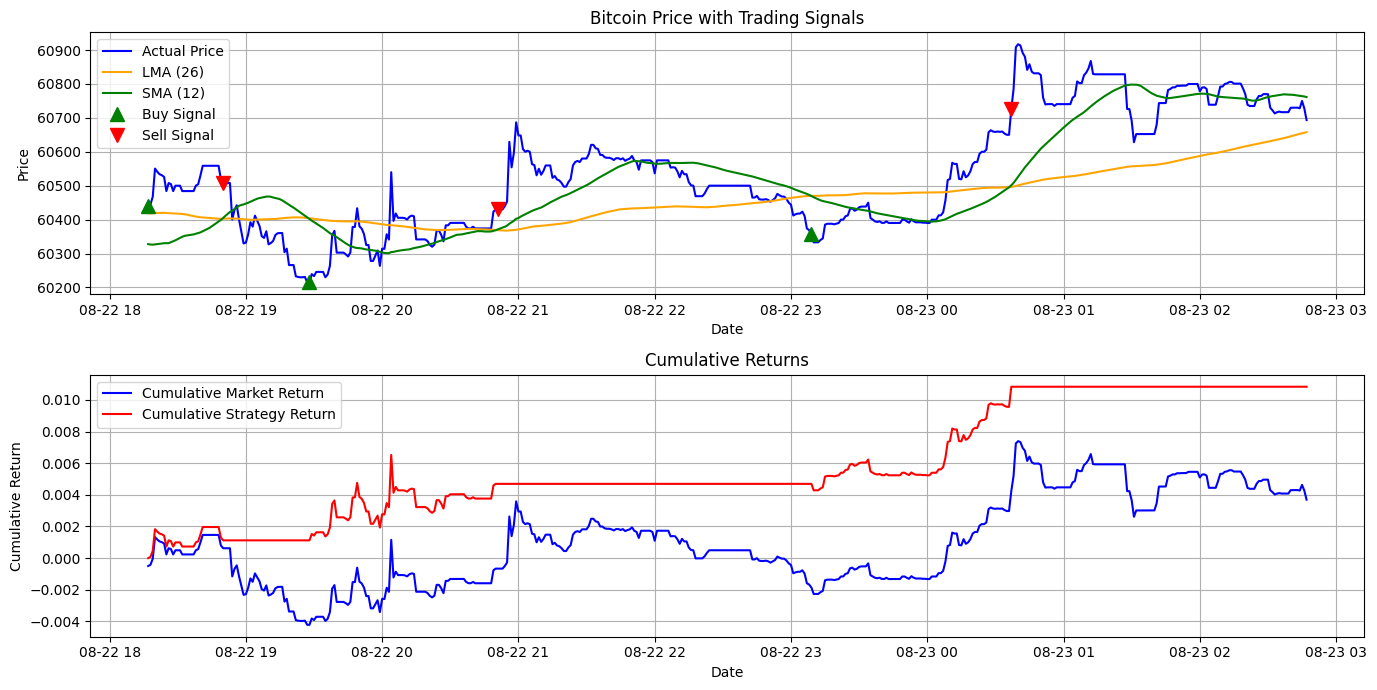

In [ ]:
# Plotting  performance
plt.figure(figsize=(14, 7))

# Plot actual price and indicators
plt.subplot(2, 1, 1)
plt.plot(df.index, df['close'], label='Actual Price', color='blue')
plt.plot(df.index, df['LMA'], label='LMA (26)', color='orange')
plt.plot(df.index, df['SMA'], label='SMA (12)', color='green')

# Plot buy signals
buy_signals = df[df['position'] == 1]
plt.plot(buy_signals.index, buy_signals['close'], '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plot sell signals
sell_signals = df[df['position'] == -1]
plt.plot(sell_signals.index, sell_signals['close'], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()

# Plot cumulative returns
plt.subplot(2, 1, 2)
plt.plot(df.index, df['cumulative_market_return'], label='Cumulative Market Return', color='blue')
plt.plot(df.index, df['cumulative_strategy_return'], label='Cumulative Strategy Return', color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()